In [1]:
import pandas as pd
import numpy as np

Now that we have imported the required libraries, we start by loading the necessary dataframes.

In [5]:
df_type_name_key = pd.read_csv("/kaggle/input/precogdata/csv/keys/keys/type_name_key.csv")
df_states = pd.read_csv("/kaggle/input/precogdata/csv/keys/keys/cases_state_key.csv")
years = [i for i in range(2010, 2019)]

These were the files that can be used while completely in memory efficiently. For the cases by year files, we will need to chunk them and work with one chunk at a time.

In [3]:
%%time     

# counter_variables
states_d = {}
states_total = {}

for i in range(1, 34):
    states_d[i] = 0
    states_total[i] = 0
    
total = 0
for year in years:

    print(f"\n{year}")
    df_year = pd.read_csv(f"/kaggle/input/precogdata/csv/cases/cases/cases_{year}.csv", low_memory=True, chunksize=100_000, iterator=True)
    
    for sub_year in df_year:
        
        df_merged = pd.merge(
            left = df_type_name_key, 
            right = sub_year, 
            on = "type_name",
            how = "inner")
        
        # keeping only the relevant columns
        df_merged = df_merged[['type_name_s', 'state_code']]
        count_states = df_merged['state_code'].value_counts().to_dict()
        
        # incrementing total counter_variable
        for i in count_states:
            states_total[i] += count_states[i]
        
        # filtering the data so we only have rows that have disp as divorve remain
        filt = df_merged["type_name_s"].str.contains("divorce", na=False)
        df_merged = df_merged[filt]
        df_grouped = df_merged.groupby(by="state_code").count()
        
        # incrementing the counter_variable for each state
        states = list(df_grouped.index)
        for state in states:
            states_d[state] += df_grouped.loc[state]['type_name_s']
            
        # progress bar
        print('.', end='')


2010
...........................................
2011
.....................................................
2012
.................................................................
2013
............................................................................
2014
.........................................................................................
2015
.........................................................................................................
2016
..................................................................................................................
2017
...................................................................................................................................
2018
..........................................................................................................................................CPU times: user 21min 55s, sys: 4min 17s, total: 26min 13s
Wall time: 28min 54s


In [6]:
states = {}
df_states_clean = df_states[['state_name', 'state_code']].drop_duplicates()

for ind in df_states_clean.index:
    states[df_states_clean['state_code'][ind]] = df_states_clean['state_name'][ind]

Setting up the states dictionary that tells us the state code.

In [59]:
res = {}

for i in range(1, 34):
    if i == 28: continue
    res[states[i]] = states_d[i]*100 / states_total[i]

Setting up the res variable that holds the conviction verdict percentage.

Glancing at the data once before plotting it.

In [60]:
for i in res:
    print(f"{i:<18}", res[i]*100)

Maharashtra        7.687828416115224
Andhra Pradesh     25.33430699949705
Karnataka          9.487707940292637
Kerala             19.289247072926493
Himachal Pradesh   14.635033210809384
Assam              3.2491802986350473
Jharkhand          10.472176824118048
Bihar              26.276717211124247
Rajasthan          7.328168416059641
Tamil Nadu         23.47234832321746
Orissa             22.59587261219831
Jammu and Kashmir  15.515427570690685
Uttar Pradesh      23.811240698001633
Haryana            24.418765103115433
Uttarakhand        70.9527495721275
West Bengal        11.547312367923514
Gujarat            6.177519838485426
Chhattisgarh       75.16074685628736
Mizoram            24.56975626801782
Tripura            4.000885993304024
Meghalaya          19.312037836918346
Punjab             22.252434895815956
Madhya Pradesh     54.451866258388335
Sikkim             19.578514708207166
Manipur            30.66984684092428
Delhi              23.82903933764306
Chandigarh         22.5582

Some states' names are different in the map data, hence we update the dataframe state names, and also convert res into a dictionary.

In [94]:
st_clean = list(res.keys())
for i in range(len(st_clean)):
    if st_clean[i] == 'Tamil Nadu':
        st_clean[i] = 'Tamilnadu'
    if st_clean[i] == 'Telangana':
        st_clean[i] = 'Telengana'
    if st_clean[i] == 'Chhattisgarh':
        st_clean[i] = 'Chhattishgarh'        
    if st_clean[i] == 'Orissa':
        st_clean[i] = 'Odisha'
    if st_clean[i] == 'DNH at Silvasa':
        st_clean[i] = 'Daman and Diu and Dadra and Nagar Haveli'
        
df = pd.DataFrame({
    'states' : st_clean,
    'vals' : res.values()
})

Importing required libraries for plotting the map.

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt 

Checking which states exist on the map but we don't have data about them.

In [85]:
shp_gdf = gpd.read_file('/kaggle/input/precogdata/maps/India-State-and-Country-Shapefile-Updated-Jan-2020-master/India_State_Boundary.shp')
for i in shp_gdf['State_Name']:
    if i not in list(df['states']):
        print(i)

Andaman & Nicobar
Lakshadweep
Puducherry
Puducherry
Arunachal Pradesh
Nagaland


Combine the map data and our data.

In [86]:
merged = pd.merge(left = shp_gdf, right = df, left_on = 'State_Name', right_on = 'states')
merged.head()

,State_Name,geometry,states,vals
0,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.400...",Chandigarh,0.225582
1,Daman and Diu and Dadra and Nagar Haveli,"MULTIPOLYGON (((8122247.822 2312434.407, 81223...",Daman and Diu and Dadra and Nagar Haveli,0.590307
2,Delhi,"POLYGON ((8583390.570 3359116.190, 8583476.212...",Delhi,0.238290
3,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392...",Haryana,0.244188
4,Jharkhand,"POLYGON ((9762288.285 2772949.712, 9762301.816...",Jharkhand,0.104722


Finally, plotting the values on the map.

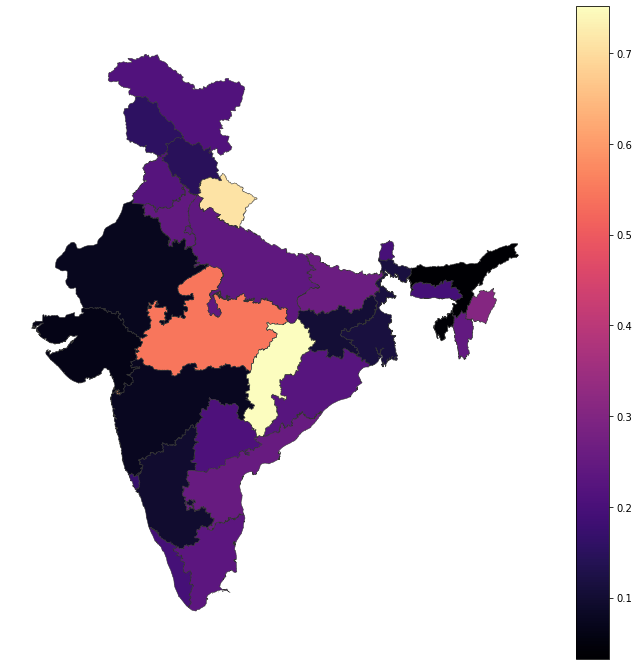

In [93]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
missing_kwds = dict(color='grey', label='No Data')

# gdf.plot(column='random', scheme='Quantiles', k= 5,
#          legend=True, legend_kwds=dict(loc='center left'),
#          missing_kwds=missing_kwds, ax=ax)

p = merged.plot(column='vals', cmap='magma', k=5, linewidth=0.5, ax=ax, edgecolor='0.2',legend=True, missing_kwds=missing_kwds)


#### We see that Chattisgarh, Uttarakhand, and Madhya Pradesh have the highest divorce case percentage.
#### Moreover, the band along west India seems to have particularly strong marriages.